In [49]:
"""
# AspenDynamicsReader
> This is a simple python module for read the time-dependent data from 
> AspenDynamics software.  
> During my research, I dealt with plenty of data pasting from software.
> It is a time consuming step, so I built it for saving my time.

### Requirement
* Have AspenDynamics software
* Inkscape: convert the svg plotfile to emf plotfile. If you don't need it.
  you can comment the code in 'plot_dynamic_results', and 'multiplot_dynamic_results'.
  
### Simple Using Step
1. You have to open the AspenDynamics file and finish the simulation at first.
2. Specified the plot setting and the plot file name for saving.
3. Run the python script.

### Future Work:
* OOP my code.
* rebuilt the data structure by python dictionary.
* built a function can save the data with ExcelFile.

### Contributor: Shen, Shiau-Jeng (johnson840205@gmail.com)

### Reference:
* Aspen Custom Modeler 2004.1 - Aspen Modeler Reference Guide

"""

"\n# AspenDynamicsReader\n> This is a simple python module for read the time-dependent data from \n> AspenDynamics software.  \n> During my research, I dealt with plenty of data pasting from software.\n> It is a time consuming step, so I built it for saving my time.\n\n### Requirement\n* Have AspenDynamics software\n* Inkscape: convert the svg plotfile to emf plotfile. If you don't need it.\n  you can comment the code in 'plot_dynamic_results', and 'multiplot_dynamic_results'.\n  \n### Simple Using Step\n1. You have to open the AspenDynamics file and finish the simulation at first.\n2. Specified the plot setting and the plot file name for saving.\n3. Run the python script.\n\n### Future Work:\n* OOP my code.\n* rebuilt the data structure by python dictionary.\n* built a function can save the data with ExcelFile.\n\n### Contributor: Shen, Shiau-Jeng (johnson840205@gmail.com)\n\n### Reference:\n* Aspen Custom Modeler 2004.1 - Aspen Modeler Reference Guide\n\n"

In [50]:
class ADConnector:
    def __init__(self, path=None, version=None):
        """Launch the AspenDynamics by the program. You can specified the path to open the file or just
        open the file by yourself.
        
        :param path: a exist AspenDynamics file path. If it's None. It will read the file you open.
        :param version: specified the version of AspenDynamics. for V10, 3600. for V8.8, 3400.
        """
        import win32com.client as win32
        # 連動 AspenDynamics 程式!!!
        if version is None:
            self.ad = win32.Dispatch('AD Application')
        else:
            self.ad = win32.Dispatch(f'AD Application {version}')
        
        if path is None:
            # 匯入當前正在跑的檔案到程式裡面，並創造一個'模擬檔案'的物件
            self.ad_sim = self.ad.Simulation
            print(self.ad_sim.Name)  # 確認檔名對不對
            # 將檔案中的製程匯入
            self.ad_flowsheet = self.ad_sim.Flowsheet
        else:
            pass
        # TODO: 新增用程式開啟檔案之指令，
        #  不過要解決輸入字串但判別不出字串的問題

    @staticmethod        
    def read_data(variables):
        """Read the specified AspenDynamics time-dependent parameter.
        The parameter should be set on a form.
        
        :param variables: a list of ADConnector Object.
        :return: a set of dictionary data with a list.
        """
        import re
        # 所有輸出的資料都會在這列表當中
        data_set = []
        
        # 先建立時間序列
        variable_record = variables[0][0].history          # 取得物流流量
        record_interval = variable_record.Interval         # 取得紀錄區間
        record_starttime = variable_record.StartTime       # 取得紀錄開始時間
        record_endtime = variable_record.EndTime           # 取得紀錄結束時間
    
        time_dic = {'Name': 'Time',                        # 時間的標題: Time
                    'Unit': 'hr',                          # 時間的單位: hr
                    'Data': []}                            # 時間的數據
    
        for pre_time in range(int(record_starttime), int(record_endtime/record_interval+1)):
            time = pre_time*record_interval
            time_dic['Data'].append(time)
        
        # 把時間序列加進數據列表當中
        data_set.append(time_dic)
        
        # 開始讀取數據
        name_match = re.compile(r"[A-Z]+\([\'|\"](\w+)[\'|\"]\).")    # 抓取單元或物流名稱用的正則表達式
        controller_name_match = re.compile(r"(\w+).(PV|OP)")          # 抓取控制器名稱用的正則表達式
        for pre_obj in variables:                                     # pre_obj=(AspenObject, axial_label)
            obj = pre_obj[0]
            label_name = pre_obj[1]                                   # 顯示在座標軸上面的label
            
            # 控制器變數名稱的判別跟物流或單元不一樣，因此要使用邏輯判斷以個別處理
            if obj.TypeName == 'control_signal':
                var_name = controller_name_match.search(obj.Name).group(1)  # 控制器名稱
            else:   
                var_name = name_match.search(obj.Name).group(1)             # 單元或物流的名稱
            
            var_unit = obj.Units                                      # 單元或物流變數的單位
            
            var_dic = {'Name': var_name + ', ' + label_name, 
                       'Unit': var_unit, 
                       'Data': []}                                    # 目前該變數的所以資訊都會匯入到此列表，換個變數後即清空
    
            record_data = obj.History                                 # 所有的數據都在這history類別裡面
            # 用個迴圈把數據一個一個加到 var_dic['Data'] 當中
            for pre_time in range(int(record_starttime), int(record_endtime/record_interval+1)):
                time = pre_time*record_interval
                var_dic['Data'].append(record_data.AtTime(time))
            
            # 如果數據資料長度跟時間長度不一致，需要檢查一下看出了什麼錯誤
            if len(var_dic['Data']) != len(time_dic['Data']):
                raise IndexError("The Data length is not equal to the time set, Pleas Check the Code !!!")
                
            # 數據長度與時間長度一致，就加入到 data_set 裡吧~
            data_set.append(var_dic)
              
        return data_set
    
    @staticmethod
    def set_time0_at(data, attime):
        """Reset the time of the given data at specified time.
    
        :param data: AspenDynamicReader-Type data
        :param attime: zeroing time point you want
        :return: zeroed data
        """
        import copy
        
        new_time = [i - attime for i in data[0]['Data']]
        new_data = copy.deepcopy(data)
        new_data[0]['Data'] = new_time
        return new_data
        
    def blocks_list(self):
        """Return a list of name of all blocks in AspenDynamics File.
        
        :return: a list contains all block's name in the AD File.
        """
        b_list = []
        for block in self.ad_flowsheet.Blocks:
            b_list.append(block.Name)
    
        return b_list
    
    def streams_list(self):
        """Return a list of name of all streams in AspenDynamics File.
        
        :return: a list contains all stream's name in the AD File.
        """
        s_list = []
        for stream in self.ad_flowsheet.Streams:
            s_list.append(stream.Name)
    
        return s_list

    def stream_moleflowrate(self, sname):
        """Return the AD Object of specified stream moleflowrate.
        
        :param sname: available stream name in the file.
        :return: AD Object of specified stream moleflowrate.
        """
        return self.ad_flowsheet.Streams(sname).F, "Moleflowrate"
    
    def stream_molefraction(self, sname, component):
        """Return the AD Object of specified stream  and component mole fraction.
        
        :param sname: available stream name in the file.
        :param component: available component name in the file.
        :return: AD Object of specified stream  and component mole fraction.
        """
        return self.ad_flowsheet.Streams(sname).Zn(component), f"MoleFrac. of {component}"
    
    def column_qr(self, bname):
        """Return the AD Object of specified RadFrac's reboiler duty.
        
        :param bname: available RadFrac name in the file.
        :return: AD Object of specified RadFrac's reboiler duty.
        """
        return self.ad_flowsheet.Blocks(bname).QReb, "QR"
    
    def column_stage_temperature(self, bname, stage):
        """Return the AD Object of specified RadFrac and stage temperature.
        
        :param bname: available RadFrac name in the file.
        :param stage: available specified RadFrac stage number in the file.
        :return: AD Object of specified RadFrac and stage temperature.
        """
        return self.ad_flowsheet.Blocks(bname).Stage(stage).T, f"T{stage}"
    
    def controller_pv(self, bname):
        """Return the AD Object of specified controller PV value.
        
        :param bname: available controller name in the file.
        :return: AD Object of specified controller PV value.
        """
        return self.ad_flowsheet.Blocks(bname).PV, "PV"
    
    def controller_op(self, bname):
        """Return the AD Object of specified controller OP value.
        
        :param bname: available controller name in the file.
        :return: AD Object of specified controller OP value.
        """
        return self.ad_flowsheet.Blocks(bname).OP, "OP"
    
    def controller_sp(self, bname):
        """Return the AD Object of specified controller SP value.
        
        :param bname: available controller name in the file.
        :return: AD Object of specified controller SP value.
        """
        return self.ad_flowsheet.Blocks(bname).SP, "SP"

In [51]:
class ADPlot:
    import matplotlib.pyplot as plt
    import subprocess, math ,itertools

    def plot_dynamic_results(self, 
                             data_set, 
                             save_filename, 
                             figure_size=(7, 5), 
                             font_style="Times New Roman", 
                             num_of_column=2):
        """將指定的動態數據畫成圖，格式為(2C *R)
        """
        fig = self.plt.figure(figsize=figure_size)                            # 創造一個圖並設定整個圖的大小
        self.plt.rcParams["font.family"] = font_style                   # 設定整個圖的字型
        
        num_plot = len(data_set)-1             # 計算要畫幾張圖(減去Time那欄)
        num_plot_row = self.math.ceil(num_plot/num_of_column)   # 計算整個圖要幾個row
        
        # 讀取數據畫圖中......
        ax_obj_list = []                                               # 儲存圖物件的列表(客製化操作用)
        for i in range(1, num_plot+1):
            ax = fig.add_subplot(num_plot_row, num_of_column, i)
            ax_obj_list.append(ax)
            line = ax.plot(data_set[0]['Data'], data_set[i]['Data'], 'b-')     # 排除數據標題後的數據
            ax.set_xlim(0, data_set[0]['Data'][-1])
            ax.set_xlabel('Time (hr)')
            ax.set_ylabel(f'{data_set[i]["Name"]} ({data_set[i]["Unit"]})')
            self.user_plot_setting(i, ax_obj_list=ax_obj_list, line=line)            # 使用者自訂的一些圖形規格(ex: 座標標籤、座標scale......)
            
        self.plt.tight_layout()
        
        # 儲存向量圖檔svg並利用inkscape軟體轉乘emf檔
        filename = save_filename
        self.plt.savefig(filename + '.svg')
        self.subprocess.call('C:\\Program Files\\Inkscape\\inkscape.exe ' + filename
                        + '.svg ' + '--export-emf=' + filename + '.emf')
    
        self.plt.show()

    def multiplot_dynamic_results(self, 
                                  data_set_group, 
                                  save_filename, 
                                  figure_size=(7, 5), 
                                  font_style="Times New Roman", 
                                  num_of_column=2, 
                                  set_legend_for_each_data_group=None):
        """將指定的動態數據畫成圖，格式為(2C *R)，座標標籤預設為第一組資料的座標label
        """
        # 判斷如果有一組以上的數據要重疊的話，確認每組數據變數是否數量一樣
        if len(data_set_group) > 1:
            data_length_list = []
            for i_data in data_set_group:
                data_length_list.append(len(i_data))
            if len(set(data_length_list)) != 1:
                raise IndexError('The length of each data set which want to merge')
            
        fig = self.plt.figure(figsize=figure_size)                      # 設定整個圖的大小
        self.plt.rcParams["font.family"] = font_style                   # 設定整個圖的字型
        
        num_plot = len(data_set_group[0])-1                # 計算要畫幾張圖(減去Time那欄)
        num_plot_row = self.math.ceil(num_plot/num_of_column)   # 計算整個圖要幾個row
        
        # 讀取數據畫圖中......
        ax_list = []                               # 把全部的圖物件都放到列表當中，之後回傳以客製化
        line_group_list = []                       # 把全部圖的線物件都放到列表當中，之後回傳以客製化
        for i in range(1, num_plot+1):
            ax = fig.add_subplot(num_plot_row, num_of_column, i)
            ax_list.append(ax)
            
            for num_plot in data_set_group:
                line = ax.plot(num_plot[0]['Data'], num_plot[i]['Data'])        # 各數據標題後的數據
            line_group_list.append(ax.lines)
            
            ax.set_xlim(0, data_set_group[0][0]['Data'][-1])    # 時間座標的上限預設為第一組資料的最後一個時間點
            ax.set_xlabel('Time (hr)')
            ax.set_ylabel(f'{data_set_group[0][i]["Name"]} ({data_set_group[0][i]["Unit"]})')   # y_label預設為第一組資料的每個類別名稱
            
        self.user_multiplot_setting(ax_list=ax_list, 
                               line_group_list=line_group_list) # 使用者自訂的一些圖形規格(ex: 座標標籤、座標scale......)
        
        # 設定legend的迴圈
        ax_list_length = len(ax_list)
        data_set_length = len(data_set_group)
        if set_legend_for_each_data_group is not None:
            # 替每個圖中的每條線設定lebel (設定legend的前置作業)
            for ax_index, line_index in self.itertools.product(range(ax_list_length), range(data_set_length)):
                line_group_list[ax_index][line_index].set_label(set_legend_for_each_data_group[line_index])
                
            # 替每個圖放上legend
            for ax_object in ax_list:
                ax_object.legend(loc='best')
            
        self.plt.tight_layout()
        
        # 儲存向量圖檔svg並利用inkscape軟體轉乘emf檔
        filename = save_filename
        self.plt.savefig(filename + '.svg')
        self.subprocess.call('C:\\Program Files\\Inkscape\\inkscape.exe ' + filename
                        + '.svg ' + '--export-emf=' + filename + '.emf')
    
        self.plt.show()

    def user_plot_setting(self, index, ax_obj_list, line):
        """客製化特定圖形的細節參數，需要自己寫一些程式碼就是，好像有點爛
        """
        pass
    
    def user_multiplot_setting(self, ax_list, line_group_list):
        """客製化特定圖形的細節參數，需要自己寫一些程式碼就是，好像有點爛
        """
        pass
    
    def change_one_ylabel(self, index_of_plot, label, ax_obj_list):
        if index_of_plot == 1:
            ax_obj_list[index_of_plot-1].set_ylabel(label)    
    
    def change_one_xlabel(self, index_of_plot, label, ax_obj_list):
        if index_of_plot == 1:
            ax_obj_list[index_of_plot-1].set_xlabel(label)
            
    def change_all_ylabel(self, label_list, ax_obj_list):
        for ax_index, label in self.itertools.zip_longest(range(len(ax_obj_list)), label_list):
            ax_obj_list[ax_index].set_ylabel(label)
    
    def change_all_xlabel(self, label_list, ax_obj_list):
        for ax_index, label in self.itertools.zip_longest(range(len(ax_obj_list)), label_list):
            ax_obj_list[ax_index].set_xlabel(label) 
            
    def change_one_set_linestyle(self, index_of_line, style, ax_obj_list, line_group_list):
        for i in range(len(ax_obj_list)):
            line_group_list[i][index_of_line-1].set_linestyle(style)
            
    def change_one_set_linecolor(self, index_of_line, color, ax_obj_list, line_group_list):
        for i in range(len(ax_obj_list)):
            line_group_list[i][index_of_line-1].set_color(color)

Aol Dehydration with MNBE(C1=16,C2=6,Ex=4,S=46)_2TC(C1=13,C2=4)withFFQR1withQR1OR_v2.dynf


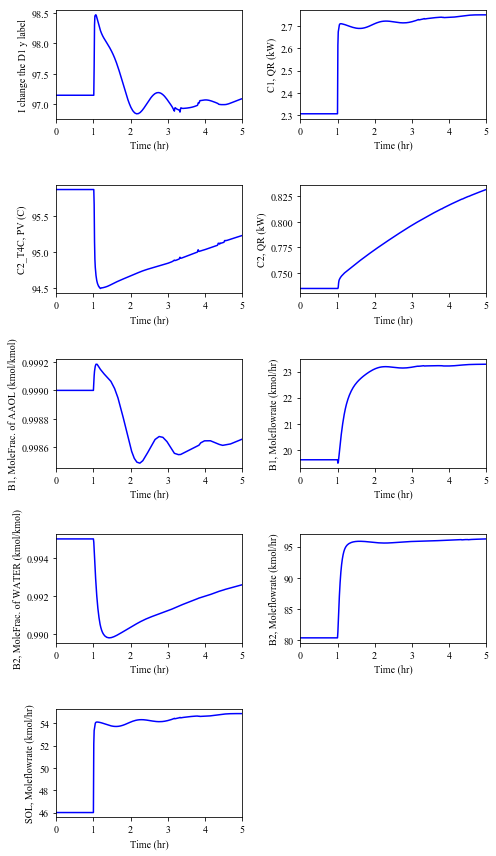

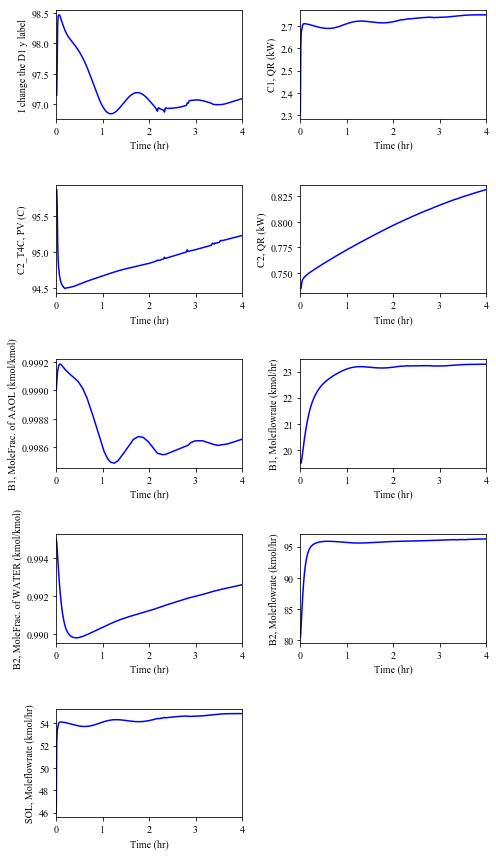

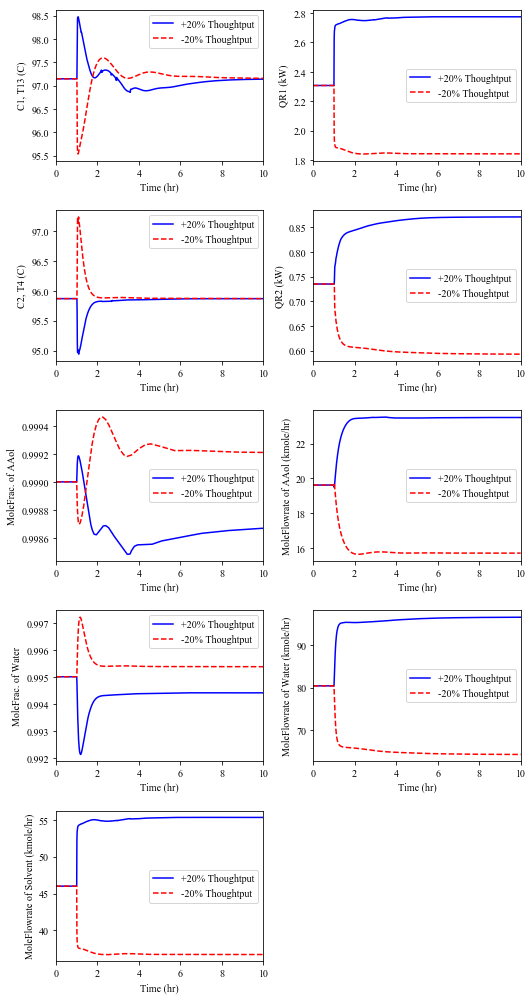

In [52]:
if __name__ == '__main__':
    import pickle
    class adplot(ADPlot):
        def user_plot_setting(self, index, ax_obj_list, line):    
            self.change_one_ylabel(1, 'I change the D1 y label', ax_obj_list)
            
        def user_multiplot_setting(self, ax_list, line_group_list):
            # plot setting change
            label_list = ['C1, T13 (C)', 'QR1 (kW)', 
                          'C2, T4 (C)', 'QR2 (kW)', 
                          'MoleFrac. of AAol', 'MoleFlowrate of AAol (kmole/hr)', 
                          'MoleFrac. of Water', 'MoleFlowrate of Water (kmole/hr)', 
                          'MoleFlowrate of Solvent (kmole/hr)']
            self.change_all_ylabel(label_list, ax_list)               
            self.change_one_set_linestyle(2, '--', ax_list, line_group_list)
            self.change_one_set_linecolor(1, 'b', ax_list, line_group_list)
            self.change_one_set_linecolor(2, 'r', ax_list, line_group_list)
    
    ad = ADConnector()
    adp = adplot()

    data = ad.read_data([ad.controller_pv('C1_T13C'), 
                         ad.column_qr('C1'), 
                         ad.controller_pv('C2_T4C'), 
                         ad.column_qr('C2'), 
                         ad.stream_molefraction('B1', 'AAOL'), 
                         ad.stream_moleflowrate('B1'), 
                         ad.stream_molefraction('B2', 'WATER'), 
                         ad.stream_moleflowrate('B2'),  
                         ad.stream_moleflowrate('SOL')])
    
#     # 將從AspenDynamics取得的資料存成 data.pickle ，如此可以再跑下一run，然後再畫圖
#     with open('data.pickle', 'ab') as f:
#         pickle.dump(data, f)

#     """
#     open()的語法
#     'wb': 以二進位打開檔案，並從頭開始寫錄資料，原本的資料會被刪除
#     'ab': 以二進位打開檔案，並從檔案後面開始寫錄資料
#     """  

    with open('data_m.pickle', 'rb') as f:
        data1 = pickle.load(f)
        data2 = pickle.load(f)

    adp.plot_dynamic_results(data, save_filename='Dynamic_result1', figure_size=(7, 12))    
    
    adp.plot_dynamic_results(ad.set_time0_at(data, 1), save_filename='Dynamic_result1', figure_size=(7, 12))

    adp.multiplot_dynamic_results([data1, data2], 
                                  save_filename='Dynamic_result2', 
                                  figure_size=(7.5, 14), 
                                  set_legend_for_each_data_group=['+20% Thoughtput', '-20% Thoughtput'])